новые вычисления модели KAN

In [11]:
import torch
from kan import KAN

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
import torch.optim as optim

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


In [12]:
df = pd.read_csv("/home/nail/Documents/Natalia/IoT/Datas/CIC_IOT_Dataset2023/IoT_Intrusion/IoT_Intrusion.csv")

In [13]:
df = df.dropna()

In [14]:
X = df[df.columns[0:-1]].fillna(0).reset_index(drop=True)
y = df['label']== 'BenignTraffic'

In [15]:
# Splitting data to train val test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=5)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=5)

# Converting data to Torch tensor
train_input = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
train_label = torch.tensor(y_train.to_numpy(), dtype=torch.long)
val_input = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
val_label = torch.tensor(y_val.to_numpy(), dtype=torch.long)
test_input = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
test_label = torch.tensor(y_test.to_numpy(), dtype=torch.long)

# Проверка размеров полученных выборок
print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

Train size: 734002
Validation size: 157286
Test size: 157287


In [16]:
# Проверка баланса классов в обучающей, валидационной и тестовой выборках
print("Class distribution in training set:")
print(y_train.value_counts())

print("\nClass distribution in validation set:")
print(y_val.value_counts())

print("\nClass distribution in test set:")
print(y_test.value_counts())

Class distribution in training set:
label
False    716842
True      17160
Name: count, dtype: int64

Class distribution in validation set:
label
False    153578
True       3708
Name: count, dtype: int64

Class distribution in test set:
label
False    153679
True       3608
Name: count, dtype: int64


In [17]:
# Проверка баланса классов с PyTorch
train_class_counts = torch.bincount(train_label)
val_class_counts = torch.bincount(val_label)
test_class_counts = torch.bincount(test_label)

print(f"Class distribution in training set: {train_class_counts}")
print(f"Class distribution in validation set: {val_class_counts}")
print(f"Class distribution in test set: {test_class_counts}")

Class distribution in training set: tensor([716842,  17160])
Class distribution in validation set: tensor([153578,   3708])
Class distribution in test set: tensor([153679,   3608])


In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score
import time

# Удаление константных признаков
from sklearn.feature_selection import VarianceThreshold

# Удаляем признаки с нулевой дисперсией (константные признаки)
constant_filter = VarianceThreshold(threshold=0)  # Порог 0 удаляет только константные признаки
X_train_filtered = constant_filter.fit_transform(X_train)
X_val_filtered = constant_filter.transform(X_val)
X_test_filtered = constant_filter.transform(X_test)

# Отбор признаков
N = 10  # Количество отбираемых признаков
selector = SelectKBest(f_classif, k=N)
X_train_selected = selector.fit_transform(X_train_filtered, y_train)
X_val_selected = selector.transform(X_val_filtered)
X_test_selected = selector.transform(X_test_filtered)

# Обучение модели с взвешиванием классов
model = RandomForestClassifier(class_weight='balanced')
model.fit(X_train_selected, y_train)

# Прогнозирование на валидационных данных
y_pred = model.predict(X_val_selected)

# Оценка точности
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy with top {N} features: {accuracy:.4f}")

# Замер времени обучения
start_train_time = time.perf_counter()
model.fit(X_train_selected, y_train)
end_train_time = time.perf_counter()

# Замер времени предсказания
start_predict_time = time.perf_counter()
y_pred_logreg = model.predict(X_val_selected)
end_predict_time = time.perf_counter()

# Проверка размеров предсказанных и истинных меток
print(f"Dimensions y_val: {y_val.shape}, y_pred_logreg: {y_pred_logreg.shape}")

# Вывод времени выполнения
print(f"Training time: {end_train_time - start_train_time:.4f} seconds")
print(f"Prediction time: {end_predict_time - start_predict_time:.4f} seconds")

Accuracy with top 10 features: 0.9911
Dimensions y_val: (157286,), y_pred_logreg: (157286,)
Training time: 51.1345 seconds
Prediction time: 0.7166 seconds


In [22]:
import torch
import torch.optim as optim
import time
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif

# Проверка доступности устройства (GPU или CPU)
device = torch.device("cpu")  # Или "cuda" для GPU

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif

# Удаление постоянных признаков
constant_filter = VarianceThreshold(threshold=0)  # Удаляет все признаки с нулевой дисперсией
X_train_var = constant_filter.fit_transform(X_train)
X_val_var = constant_filter.transform(X_val)
X_test_var = constant_filter.transform(X_test)

# Шаг отбора признаков (SelectKBest)
N = 10  # Количество отбираемых признаков
selector = SelectKBest(f_classif, k=N)
X_train_selected = selector.fit_transform(X_train_var, y_train)
X_val_selected = selector.transform(X_val_var)
X_test_selected = selector.transform(X_test_var)

# Получение индексов отобранных признаков
top_n_indices = selector.get_support(indices=True)

# Вывод индексов отобранных признаков
print(f"Selected feature indices: {top_n_indices}")


# Инициализация модели
model = KAN(width=[10, [5, 3], 2], grid=5, k=2)  # Убедитесь, что модель корректно определена

# Перемещаем модель на устройство
model.to(device)

# Преобразуем отобранные данные в тензоры
train_input = torch.tensor(X_train_selected, dtype=torch.float32).to(device)
val_input = torch.tensor(X_val_selected, dtype=torch.float32).to(device)
test_input = torch.tensor(X_test_selected, dtype=torch.float32).to(device)

# Предполагается, что train_label, val_label и test_label уже преобразованы в тензоры
train_label = train_label.to(device)
val_label = val_label.to(device)
test_label = test_label.to(device)

# Проверка размеров данных
print(f"Train input shape: {train_input.shape}")
print(f"Val input shape: {val_input.shape}")
print(f"Test input shape: {test_input.shape}")


Selected feature indices: [ 3 11 16 18 30 31 32 33 37 39]
checkpoint directory created: ./model
saving model version 0.0
Train input shape: torch.Size([734002, 10])
Val input shape: torch.Size([157286, 10])
Test input shape: torch.Size([157287, 10])


In [23]:
# Оптимизатор
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Функция потерь
criterion = torch.nn.CrossEntropyLoss()

# Функция для вычисления точности
def train_acc():
    model.eval()  # Убедимся, что модель в режиме оценки (без обновления градиентов)
    with torch.no_grad():
        preds = torch.argmax(model(train_input), dim=1)
        accuracy = torch.mean((preds == train_label).float())
    print(f"Train Accuracy: {accuracy.item():.4f}")
    return accuracy

def test_acc():
    model.eval()
    with torch.no_grad():
        preds = torch.argmax(model(test_input), dim=1)
        print(classification_report(test_label,preds))
        accuracy = torch.mean((preds == test_label).float())
    print(f"Test Accuracy: {accuracy.item():.4f}")
    return accuracy

In [24]:

# Замер времени обучения
start_train_time = time.perf_counter()

# Обучение модели
for step in range(100):  # Количество шагов (итераций)
    try:
        # Обнуляем градиенты
        optimizer.zero_grad()
        
        # Прогон через модель
        outputs = model(train_input)
        
        # Вычисляем функцию потерь
        loss = criterion(outputs, train_label)
        
        # Вычисляем градиенты
        loss.backward()
        
        # Шаг оптимизатора
        optimizer.step()
        
        # Печать каждые 10 шагов
        if step % 10 == 0:
            print(f"Step {step}, Loss: {loss.item():.4f}")
    except Exception as e:
        print(f"Error at step {step}: {str(e)}")
        break

end_train_time = time.perf_counter()

# Замер времени выполнения предсказаний
start_predict_time = time.perf_counter()

model.eval()
with torch.no_grad():
    val_pred = model(val_input)

end_predict_time = time.perf_counter()

# После тренировки модели вычисляем точность
train_accuracy = train_acc()
val_accuracy = test_acc()

# Вывод результатов
print(f"Train Accuracy: {train_accuracy.item():.4f}")
print(f"Validation Accuracy: {val_accuracy.item():.4f}")

# Вывод времени обучения и времени предсказания
train_time = end_train_time - start_train_time
predict_time = end_predict_time - start_predict_time
print(f"Training Time: {train_time:.4f} seconds")
print(f"Prediction Time: {predict_time:.4f} seconds")

# Освобождаем память
torch.cuda.empty_cache()

Step 0, Loss: 330.4120
Step 10, Loss: 189.7744
Step 20, Loss: 117.6957
Step 30, Loss: 76.2960
Step 40, Loss: 65.9626
Step 50, Loss: 55.8446
Step 60, Loss: 47.5199
Step 70, Loss: 40.0253
Step 80, Loss: 34.1166
Step 90, Loss: 30.0121
Train Accuracy: 0.9777
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    153679
           1       0.50      0.42      0.46      3608

    accuracy                           0.98    157287
   macro avg       0.74      0.71      0.72    157287
weighted avg       0.98      0.98      0.98    157287

Test Accuracy: 0.9772
Train Accuracy: 0.9777
Validation Accuracy: 0.9772
Training Time: 819.4321 seconds
Prediction Time: 0.7603 seconds


F1-score: 0.4598
AUC-ROC: 0.5722
Precision for each class: [0.98651531 0.50296248]


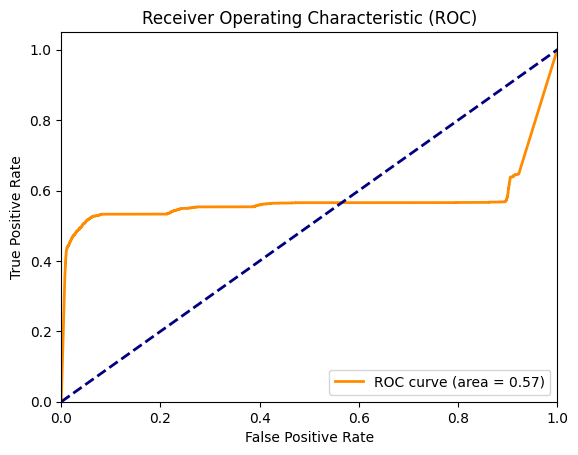

F1-score: 0.4783
AUC-ROC: 0.5898
Precision for each class: [0.98653435 0.5237484 ]


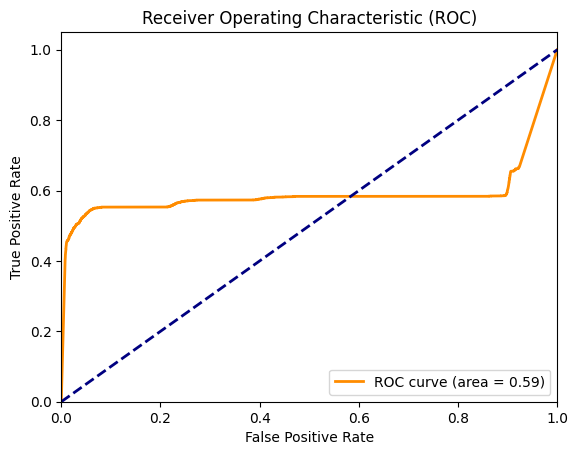

Prediction Time: 1.5328 seconds


In [25]:
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc, precision_score
import matplotlib.pyplot as plt

# Функция для вычисления F1-score, AUC-ROC и точности
def evaluate_model(preds, true_labels, preds_prob):
    # Расчёт F1-score
    f1 = f1_score(true_labels.cpu(), preds.cpu())
    print(f"F1-score: {f1:.4f}")
    
    # Расчёт AUC-ROC
    auc_roc = roc_auc_score(true_labels.cpu(), preds_prob.cpu())
    print(f"AUC-ROC: {auc_roc:.4f}")
    
    # Расчёт точности для каждого класса
    precision = precision_score(true_labels.cpu(), preds.cpu(), average=None)
    print(f"Precision for each class: {precision}")
    
    # Построение графика ROC-кривой
    fpr, tpr, thresholds = roc_curve(true_labels.cpu(), preds_prob.cpu())
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

# Вычисление вероятностей для AUC-ROC
def get_pred_prob(model, input_data):
    model.eval()
    with torch.no_grad():
        preds_prob = torch.softmax(model(input_data), dim=1)[:, 1]  # Вероятности для положительного класса
    return preds_prob

# После тренировки модели вычисляем метрики для тестовых данных
model.eval()
with torch.no_grad():
    # Прогнозирование классов и вероятностей
    test_preds = torch.argmax(model(test_input), dim=1)
    test_pred_prob = get_pred_prob(model, test_input)

    # Оценка точности
    evaluate_model(test_preds, test_label, test_pred_prob)

# Замер времени выполнения предсказаний
start_predict_time = time.perf_counter()

# Прогнозирование для валидационных данных
model.eval()
with torch.no_grad():
    val_preds = torch.argmax(model(val_input), dim=1)
    val_pred_prob = get_pred_prob(model, val_input)

end_predict_time = time.perf_counter()

# Оценка метрик для валидационных данных
evaluate_model(val_preds, val_label, val_pred_prob)

# Время предсказания
predict_time = end_predict_time - start_predict_time
print(f"Prediction Time: {predict_time:.4f} seconds")


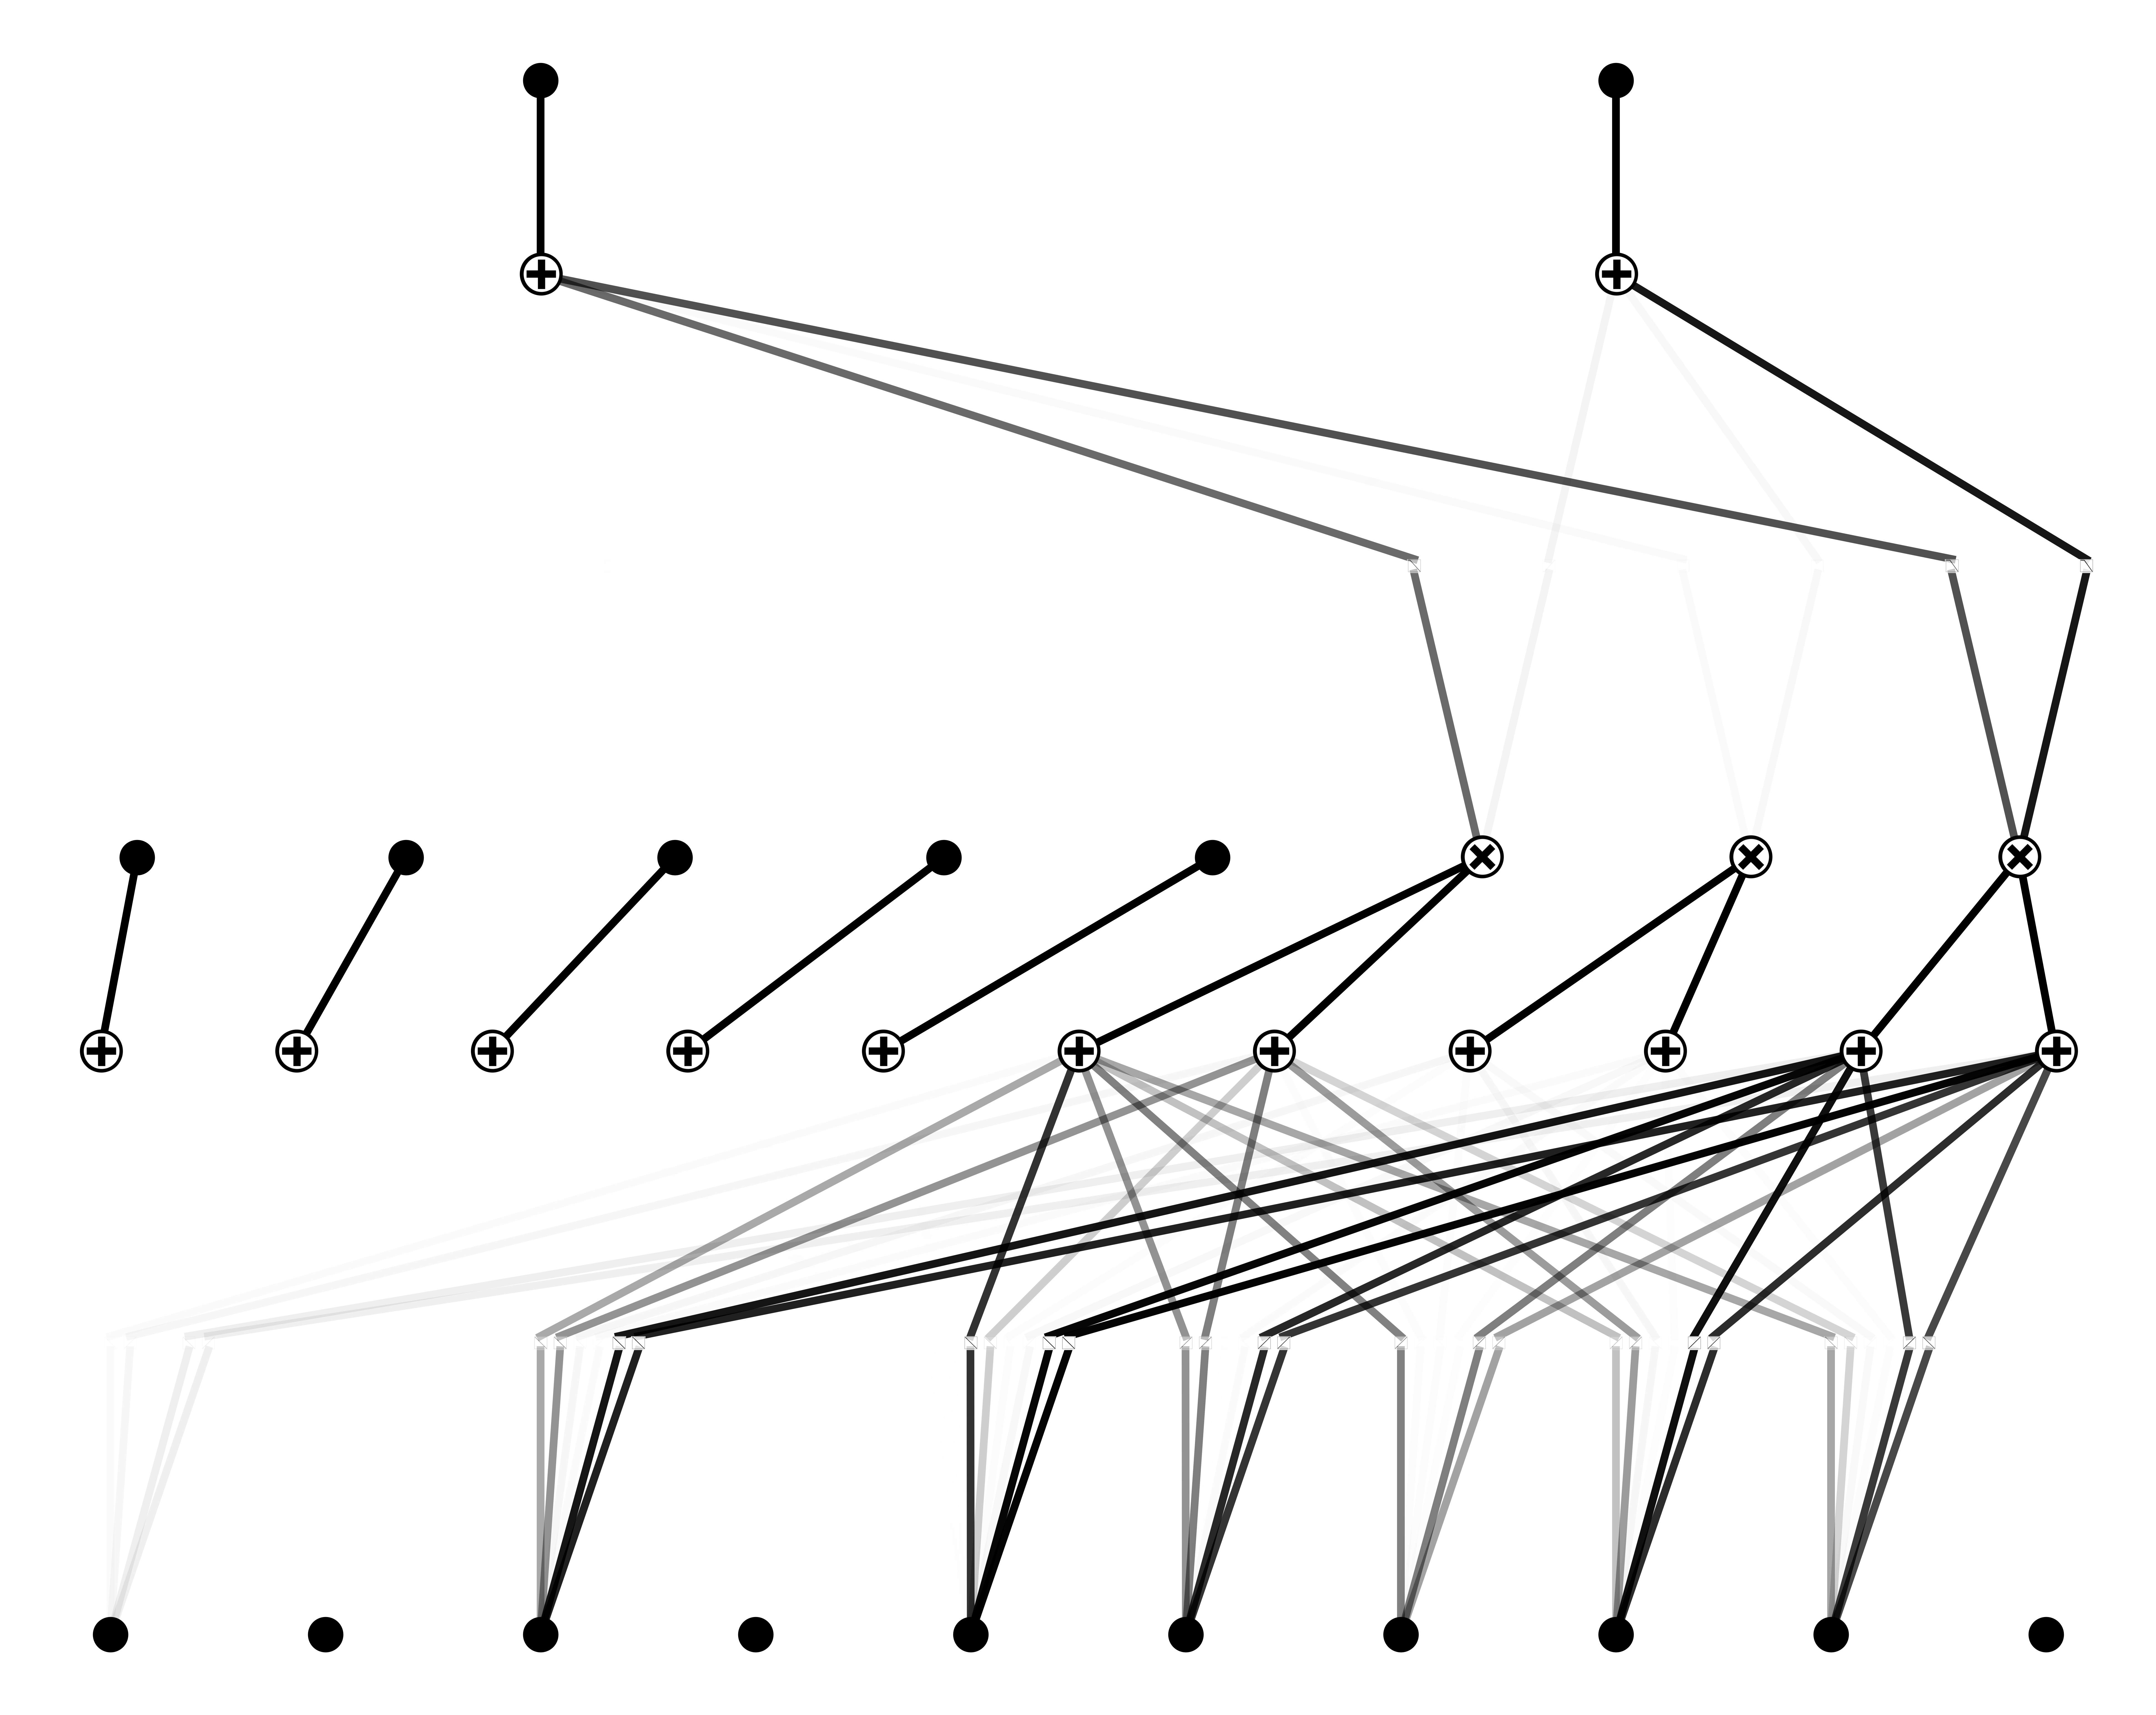

In [26]:
model.plot(scale=10)

plt.savefig("fig30.png") 

In [27]:
model = model.prune()

saving model version 0.1


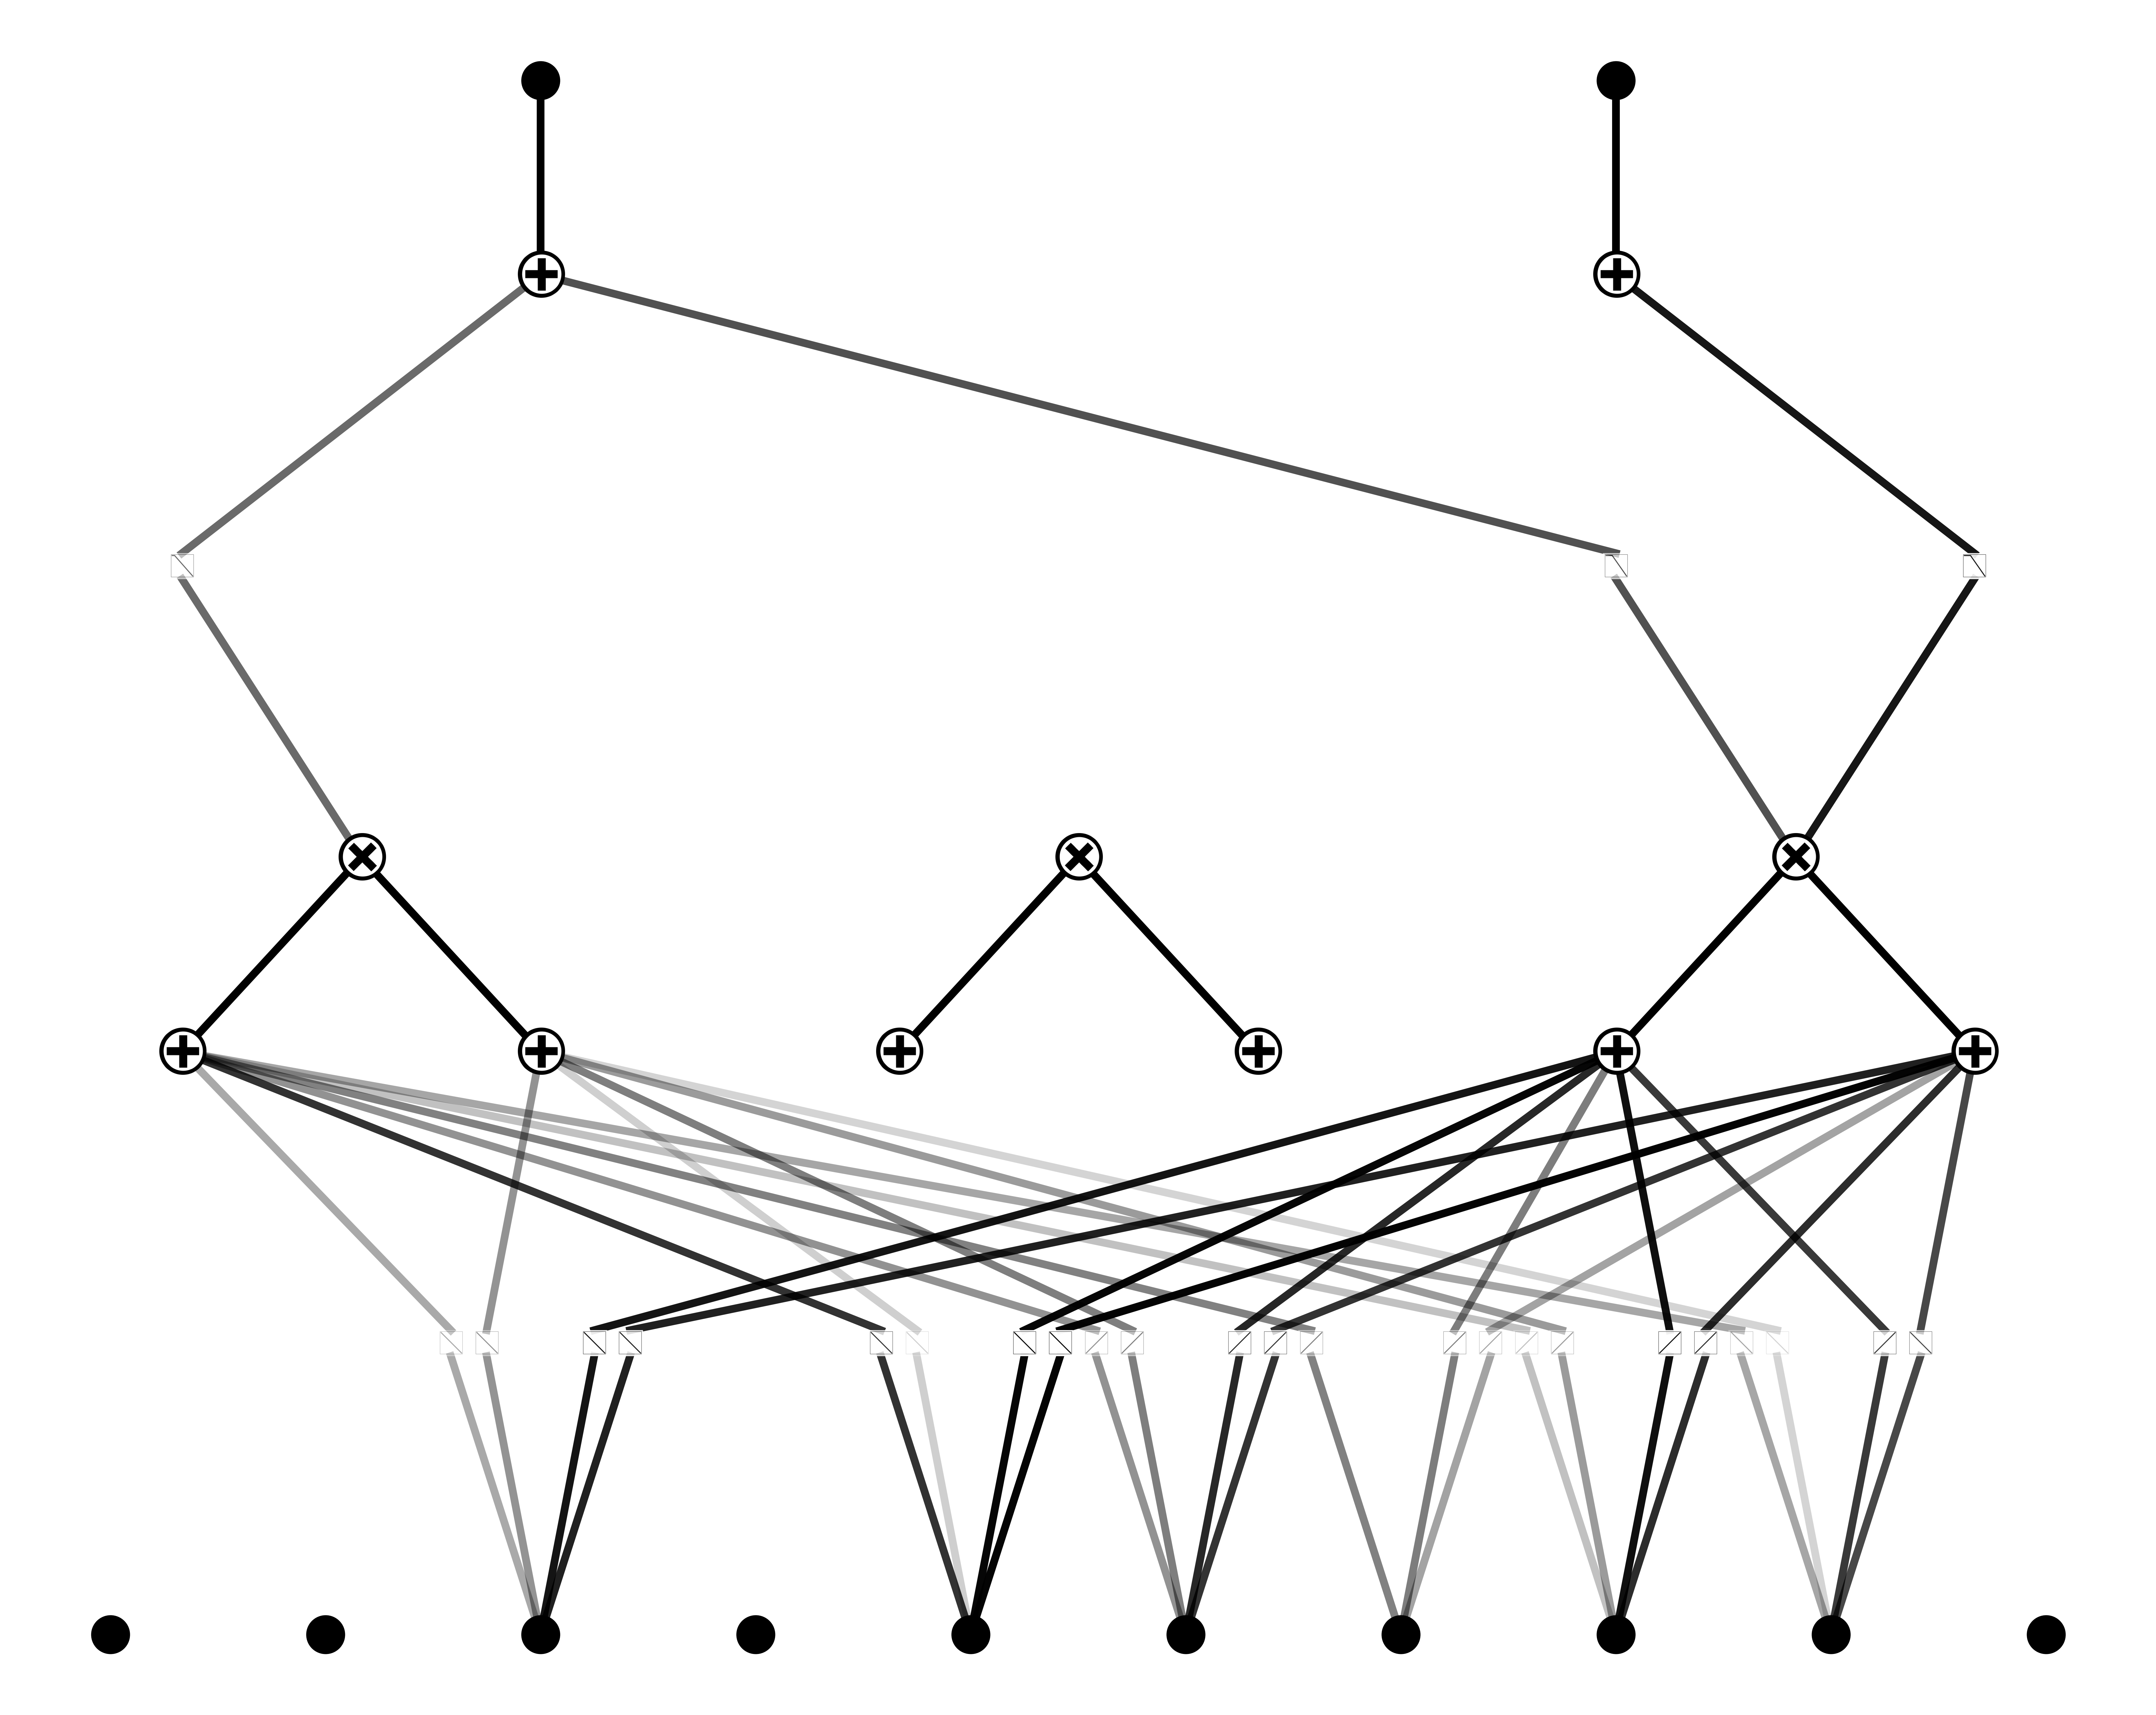

In [28]:
model.plot(scale=10)
plt.savefig("fig31.png")

In [29]:
model = model.prune()

saving model version 0.2


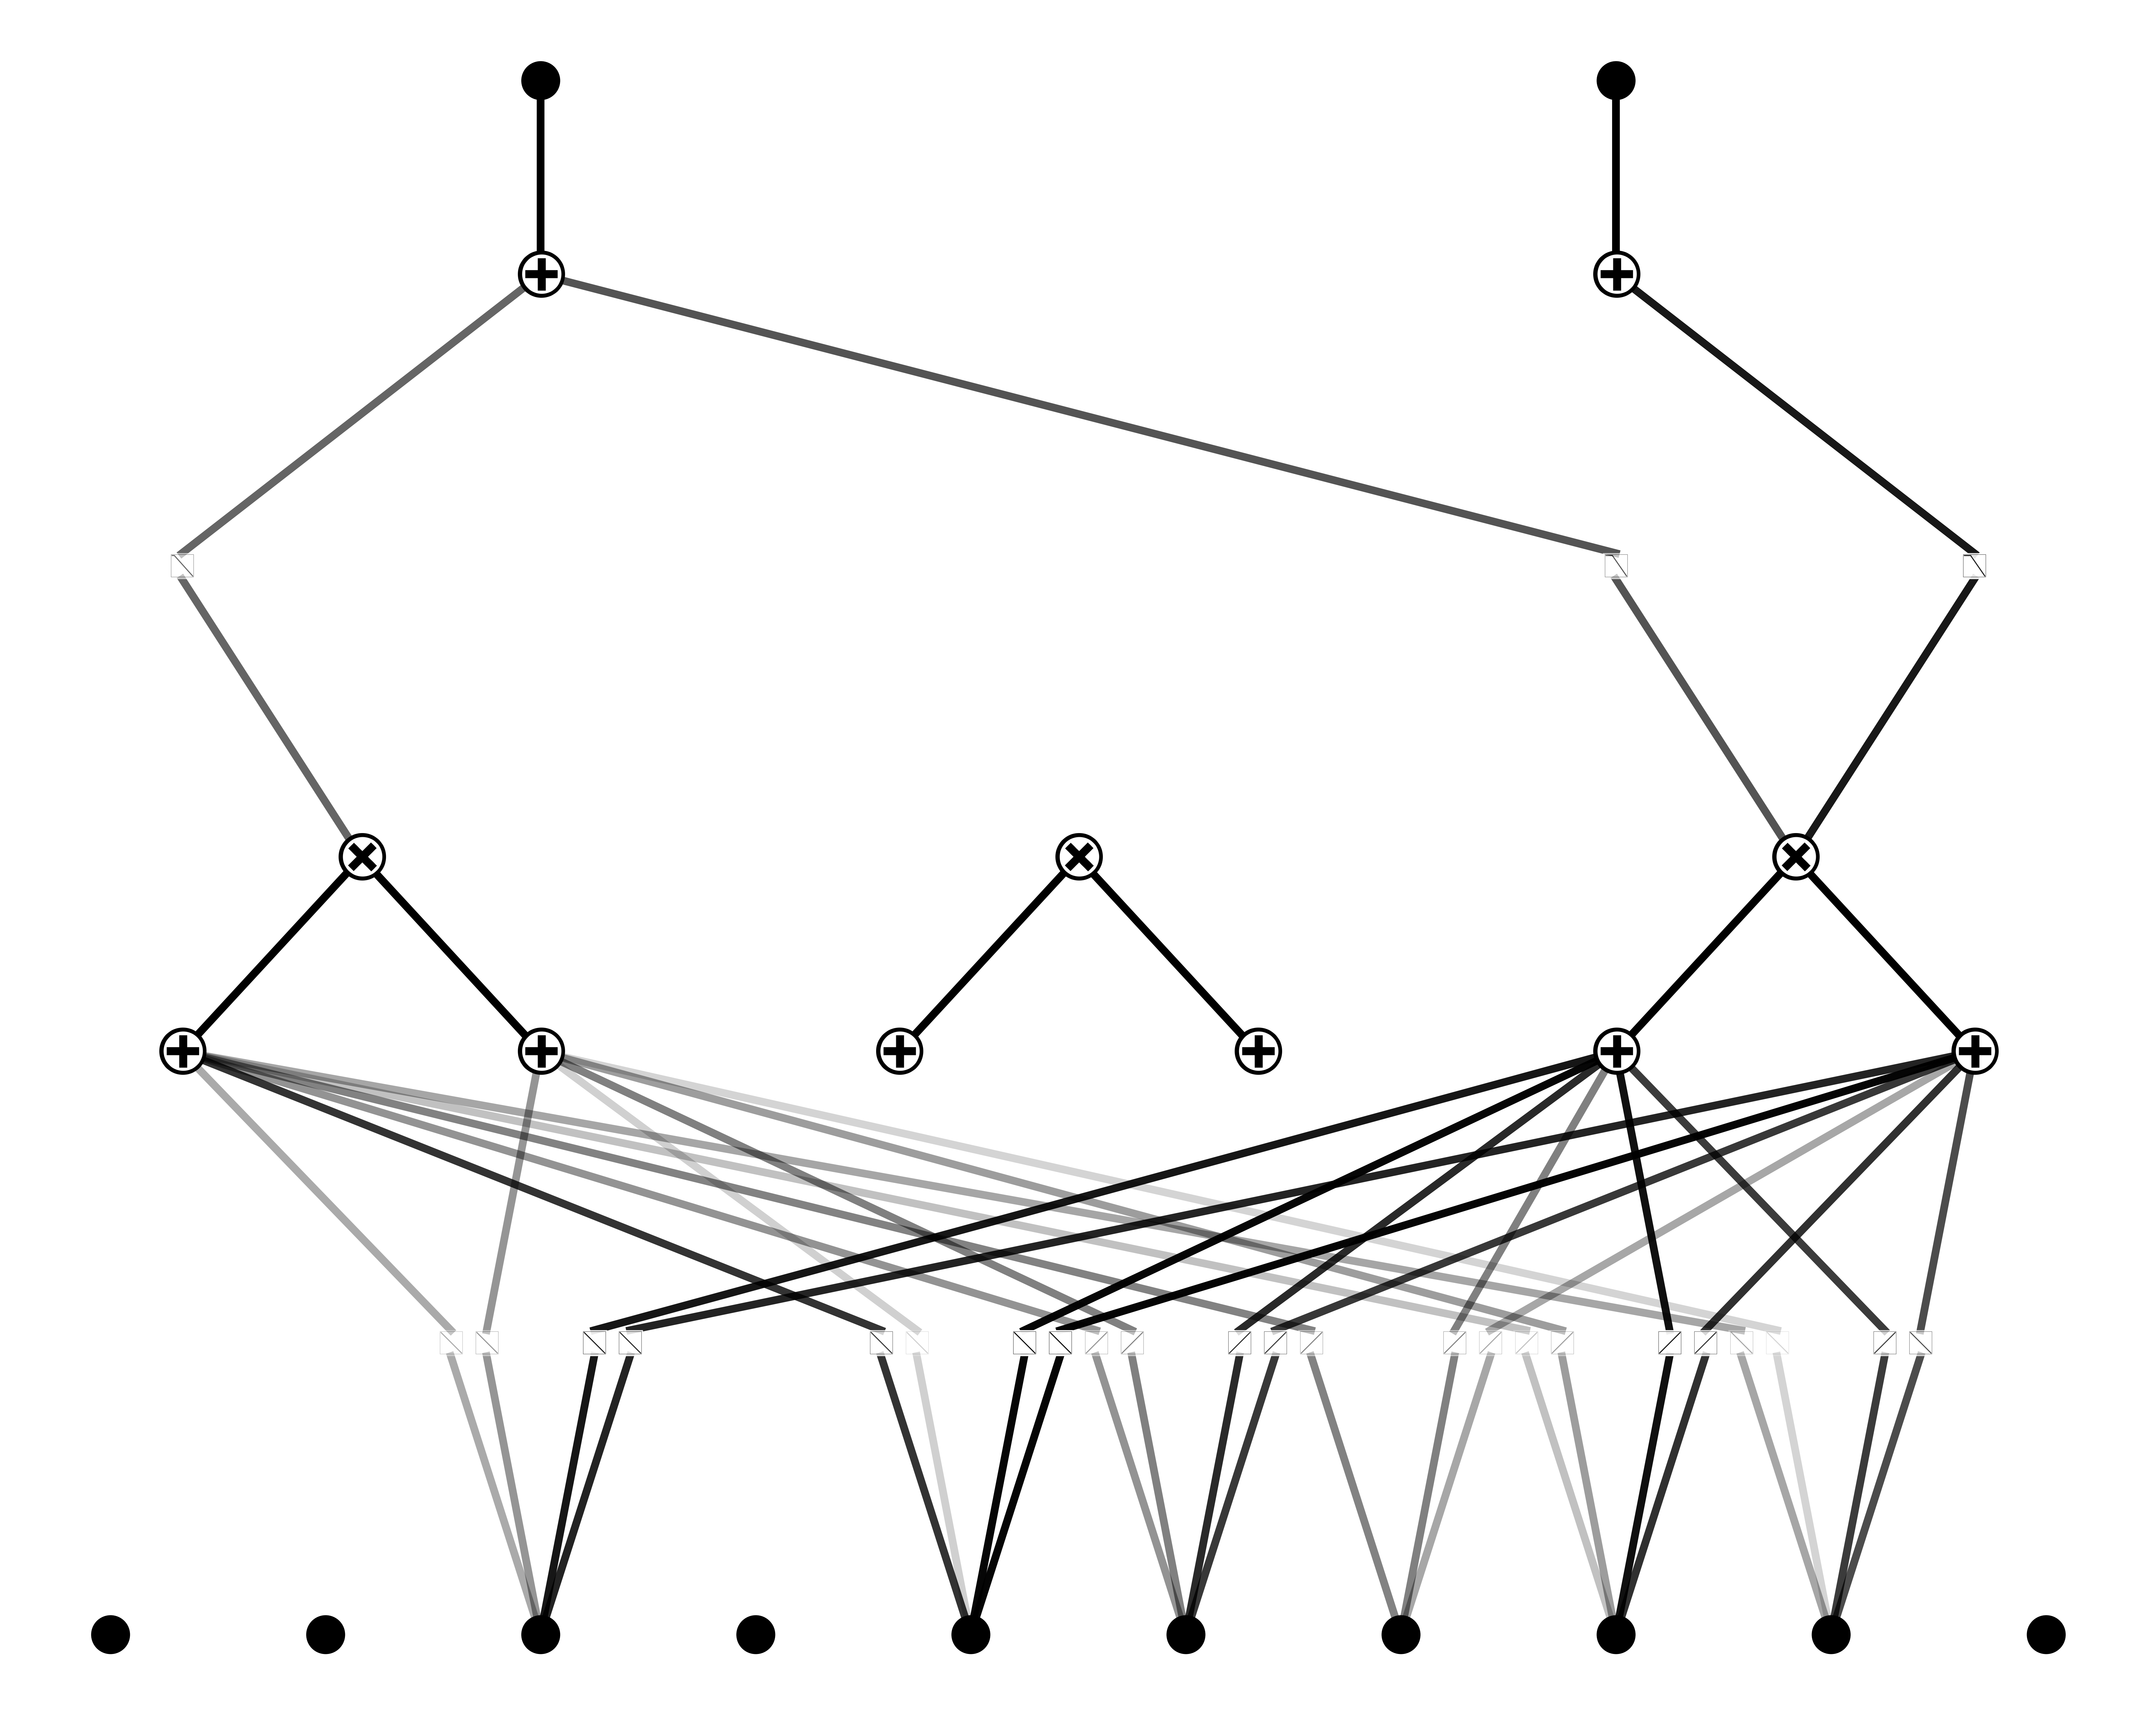

In [30]:
model.plot(scale=10)
plt.savefig("fig32.png")